In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



## Motivation



Our dataset is the Enron Email Dataset, a collection of approximately 500,000 internal emails from around 150 Enron employees—primarily executives—spanning the years 1998 to 2002. It was released by the Federal Energy Regulatory Commission (FERC) during investigations into Enron’s collapse and later curated by the CALO Project at Carnegie Mellon University.


We chose the Enron Email Dataset because it provides a rare and rich source of real-world corporate communication data that is both large-scale and publicly available. The Enron scandal is one of the most infamous cases of corporate fraud in U.S. history, involving large-scale accounting manipulation, insider trading, and ethical misconduct. This context makes the dataset highly relevant for studying patterns of communication that might signal unethical or fraudulent behavior. Moreover, it has been widely used in previous research on social network analysis and NLP, giving us a solid foundation for our work while allowing room for novel approaches.


Our goal was to explore whether natural language processing (NLP) techniques can be used to identify suspicious behavior, key individuals, or hidden communication patterns within an organization. For the end user—such as auditors, compliance officers, or investigators—we envision a tool that can enhance traditional fraud detection methods by flagging anomalous communication behavior or surfacing important actors in a corporate network. Ultimately, our aim is to contribute to tools that make large-scale communication data more interpretable and actionable in preventing or detecting fraud.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import networkx as nx
import nxviz as nv


/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## The Dataset and Data Cleaning

The Enron email corpus initially comprises over 500,000 messages exchanged among more than 5,000 unique addresses, but raw data at this scale contains a great deal of noise and automated traffic that can obscure meaningful social interactions. To produce a high‐quality network for analysis, we applied several successive filters:

1. **Remove incomplete records.** Any email lacking a valid sender, recipient, subject line, or message body was discarded. This eliminated messages that were malformed, empty, or otherwise unsuitable for content-based or network analysis.

2. **Filter out system-generated and broadcast lists.** Addresses associated with payroll, distribution lists (e.g., `all.employees`), public relations, announcement channels, “team.\*” groups, and similar automated sources were identified via keyword matching (e.g., `payroll`, `list`, `distribution`, `announcement`, `team.`) and excluded. By doing so, we focused exclusively on one-to-one or small-group human correspondence.

3. **Drop self-sent emails.** Messages where the sender and primary recipient were identical—essentially personal notes filed in one’s own inbox—were removed, since they do not represent true interpersonal communication.

4. **Constrain to truly active employees.** To emphasize the core of Enron’s social structure, we further limited the dataset to those individuals who both sent and received at least 100 emails. This dual-threshold ensures that every node in the network played a significant communicative role, reducing peripheral noise.

After these preprocessing steps, the dataset shrank from roughly **517,000** raw emails to **78,000** emails exchanged among **222** active employees. This distilled network captures the most substantial, person-to-person interactions, laying a solid foundation for centrality, community detection, and other graph-theoretic analyses.


In [3]:
pd.options.mode.chained_assignment = None

data = pd.read_csv('../emails.csv')


data.info()
len(data)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


517401

In [4]:
def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
    """returns a specified email address from each row in a Series"""
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df


In [5]:
x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data = standard_format(data, data.message, v, i)
data = data.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(data.index), np.round(((x - len(data.index)) / x) * 100, decimals=2)))


Got rid of 111433 useless emails! That's 21.54% of the total number of messages in this dataset.


In [6]:
import re

# 1) Split each message into 16 columns (0–15): the first 15 header lines + “the rest”
split_cols = data['message'].str.split(pat='\n', n=15, expand=True)

# 2) Extract the bits you want
data = data.assign(
    date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
    sender     = split_cols[2].str.replace('From: ',   '', regex=False),
    recipients = split_cols[3].str.replace('To: ',     '', regex=False),
    subject    = split_cols[4].str.replace('Subject: ','', regex=False),
    text       = split_cols[15]  # everything after the 15th newline
)

# 3) Pull out up to three “To:” addresses
addr_re = r'[\w\.-]+@[\w\.-]+\.\w+'
all_to_addrs = data['recipients'].str.findall(addr_re)
data['recipient1'] = all_to_addrs.str.get(0)
data['recipient2'] = all_to_addrs.str.get(1)
data['recipient3'] = all_to_addrs.str.get(2)

# 4) Pull out exactly one “From:” address
data['sender'] = data['sender'].str.extract(f'({addr_re})')[0]

# 5) Filter to internal Enron senders & first recipient
mask = data['sender'].str.endswith('@enron.com', na=False) & \
       data['recipient1'].str.endswith('@enron.com', na=False)
data = data[mask]

# 6) Keep only “active” senders (>50 emails)
send_counts = data['sender'].value_counts()
active    = send_counts[send_counts > 50].index
data = data[data['sender'].isin(active)]

# 7) Reorder & reset index
data = data[['date','sender','recipient1','subject','text']] \
           .reset_index(drop=True)

bad_keywords = [
    r"payroll",      # payroll.message@enron.com, etc.
    r"services",     # wholesale.services@enron.com, etc.
    r"mailout",      # xyz.mailout@enron.com
    r"list",         # enron.list@enron.com, all.list@enron.com
    r"distribution", # distribution@enron.com
    r"announcement", # ect.announcement, enron.announcements
    r"team\.",       # team.artesia, team.flagstaff-sta2
    r"dl-ga",        # dl-ga-all_domestic, dl-ga-all_enron_worldwide1
    r"public",       # public.houston, public.relations
    r"all\.",        # all.employees, all.worldwide, all.xms.users
    r"everyone",     # everyone_in_ect_houston
    r"office",       # office.chairman
    r"united",       # united.list, united.way
]
pattern = "(" + "|".join(bad_keywords) + ")"

# filter them out
good = (~data['sender']    .str.contains(pattern, case=False, na=False)
      & ~data['recipient1'].str.contains(pattern, case=False, na=False))
data = data[good].reset_index(drop=True)


recv_counts = data['recipient1'].value_counts()

# step 6.6) find those who both send >50 AND receive >50
active_senders   = send_counts[ send_counts   > 50 ].index
active_receivers = recv_counts[ recv_counts  > 50 ].index

active_both = active_senders.intersection(active_receivers)

# step 6.7) filter to only those senders
data = data[ data['sender'].isin(active_both) ]

# now you can do your reorder & reset index (step 7)
self_mask = data['sender'] == data['recipient1']
data = data[~self_mask]

# now reorder & reset index (again)
data = data[['date','sender','recipient1','subject','text']] \
           .reset_index(drop=True)

send_counts = data['sender'].value_counts()
recv_counts = data['recipient1'].value_counts()

active_senders   = set(send_counts[send_counts   > 100].index)
active_receivers = set(recv_counts[recv_counts   > 100].index)

# 1) Only keep edges where BOTH endpoints are active
active_both = active_senders & active_receivers

edges = data[
    data['sender'].isin(active_both) &
    data['recipient1'].isin(active_both)
].reset_index(drop=True)

print("Unique senders:", edges['sender'].nunique())
print("Unique recipients:", edges['recipient1'].nunique())
print("Total edges:", len(edges))




/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_15314/3288786798.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_15314/3288786798.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_15314/3288786798.py:57: UserWarning: This pattern is interpreted as a regular expression, and has m

Unique senders: 222
Unique recipients: 222
Total edges: 78458


['phillip.allen@enron.com', 'tim.belden@enron.com', 'john.lavorato@enron.com', 'greg.piper@enron.com', 'david.delainey@enron.com', 'jeffrey.hodge@enron.com', 'christopher.calger@enron.com', 'james.steffes@enron.com', 'frank.hayden@enron.com', 'mike.grigsby@enron.com', 'alan.comnes@enron.com', 'colleen.sullivan@enron.com', 'stephanie.sever@enron.com', 'hunter.shively@enron.com', 'matthew.lenhart@enron.com', 'jeffrey.gossett@enron.com', 'stanley.horton@enron.com', 'mark.taylor@enron.com', 'barry.tycholiz@enron.com', 'christi.nicolay@enron.com', 'mark.whitt@enron.com', 'susan.scott@enron.com', 'ben.jacoby@enron.com', 'steven.kean@enron.com', 'paul.kaufman@enron.com', 'andy.zipper@enron.com', 'stephanie.miller@enron.com', 'jeff.dasovich@enron.com', 'kim.ward@enron.com', 'richard.shapiro@enron.com', 'leslie.lawner@enron.com', 'kam.keiser@enron.com', 'john.arnold@enron.com', 'jeffrey.shankman@enron.com', 'david.forster@enron.com', 'john.griffith@enron.com', 'kevin.presto@enron.com', 'greg.wh

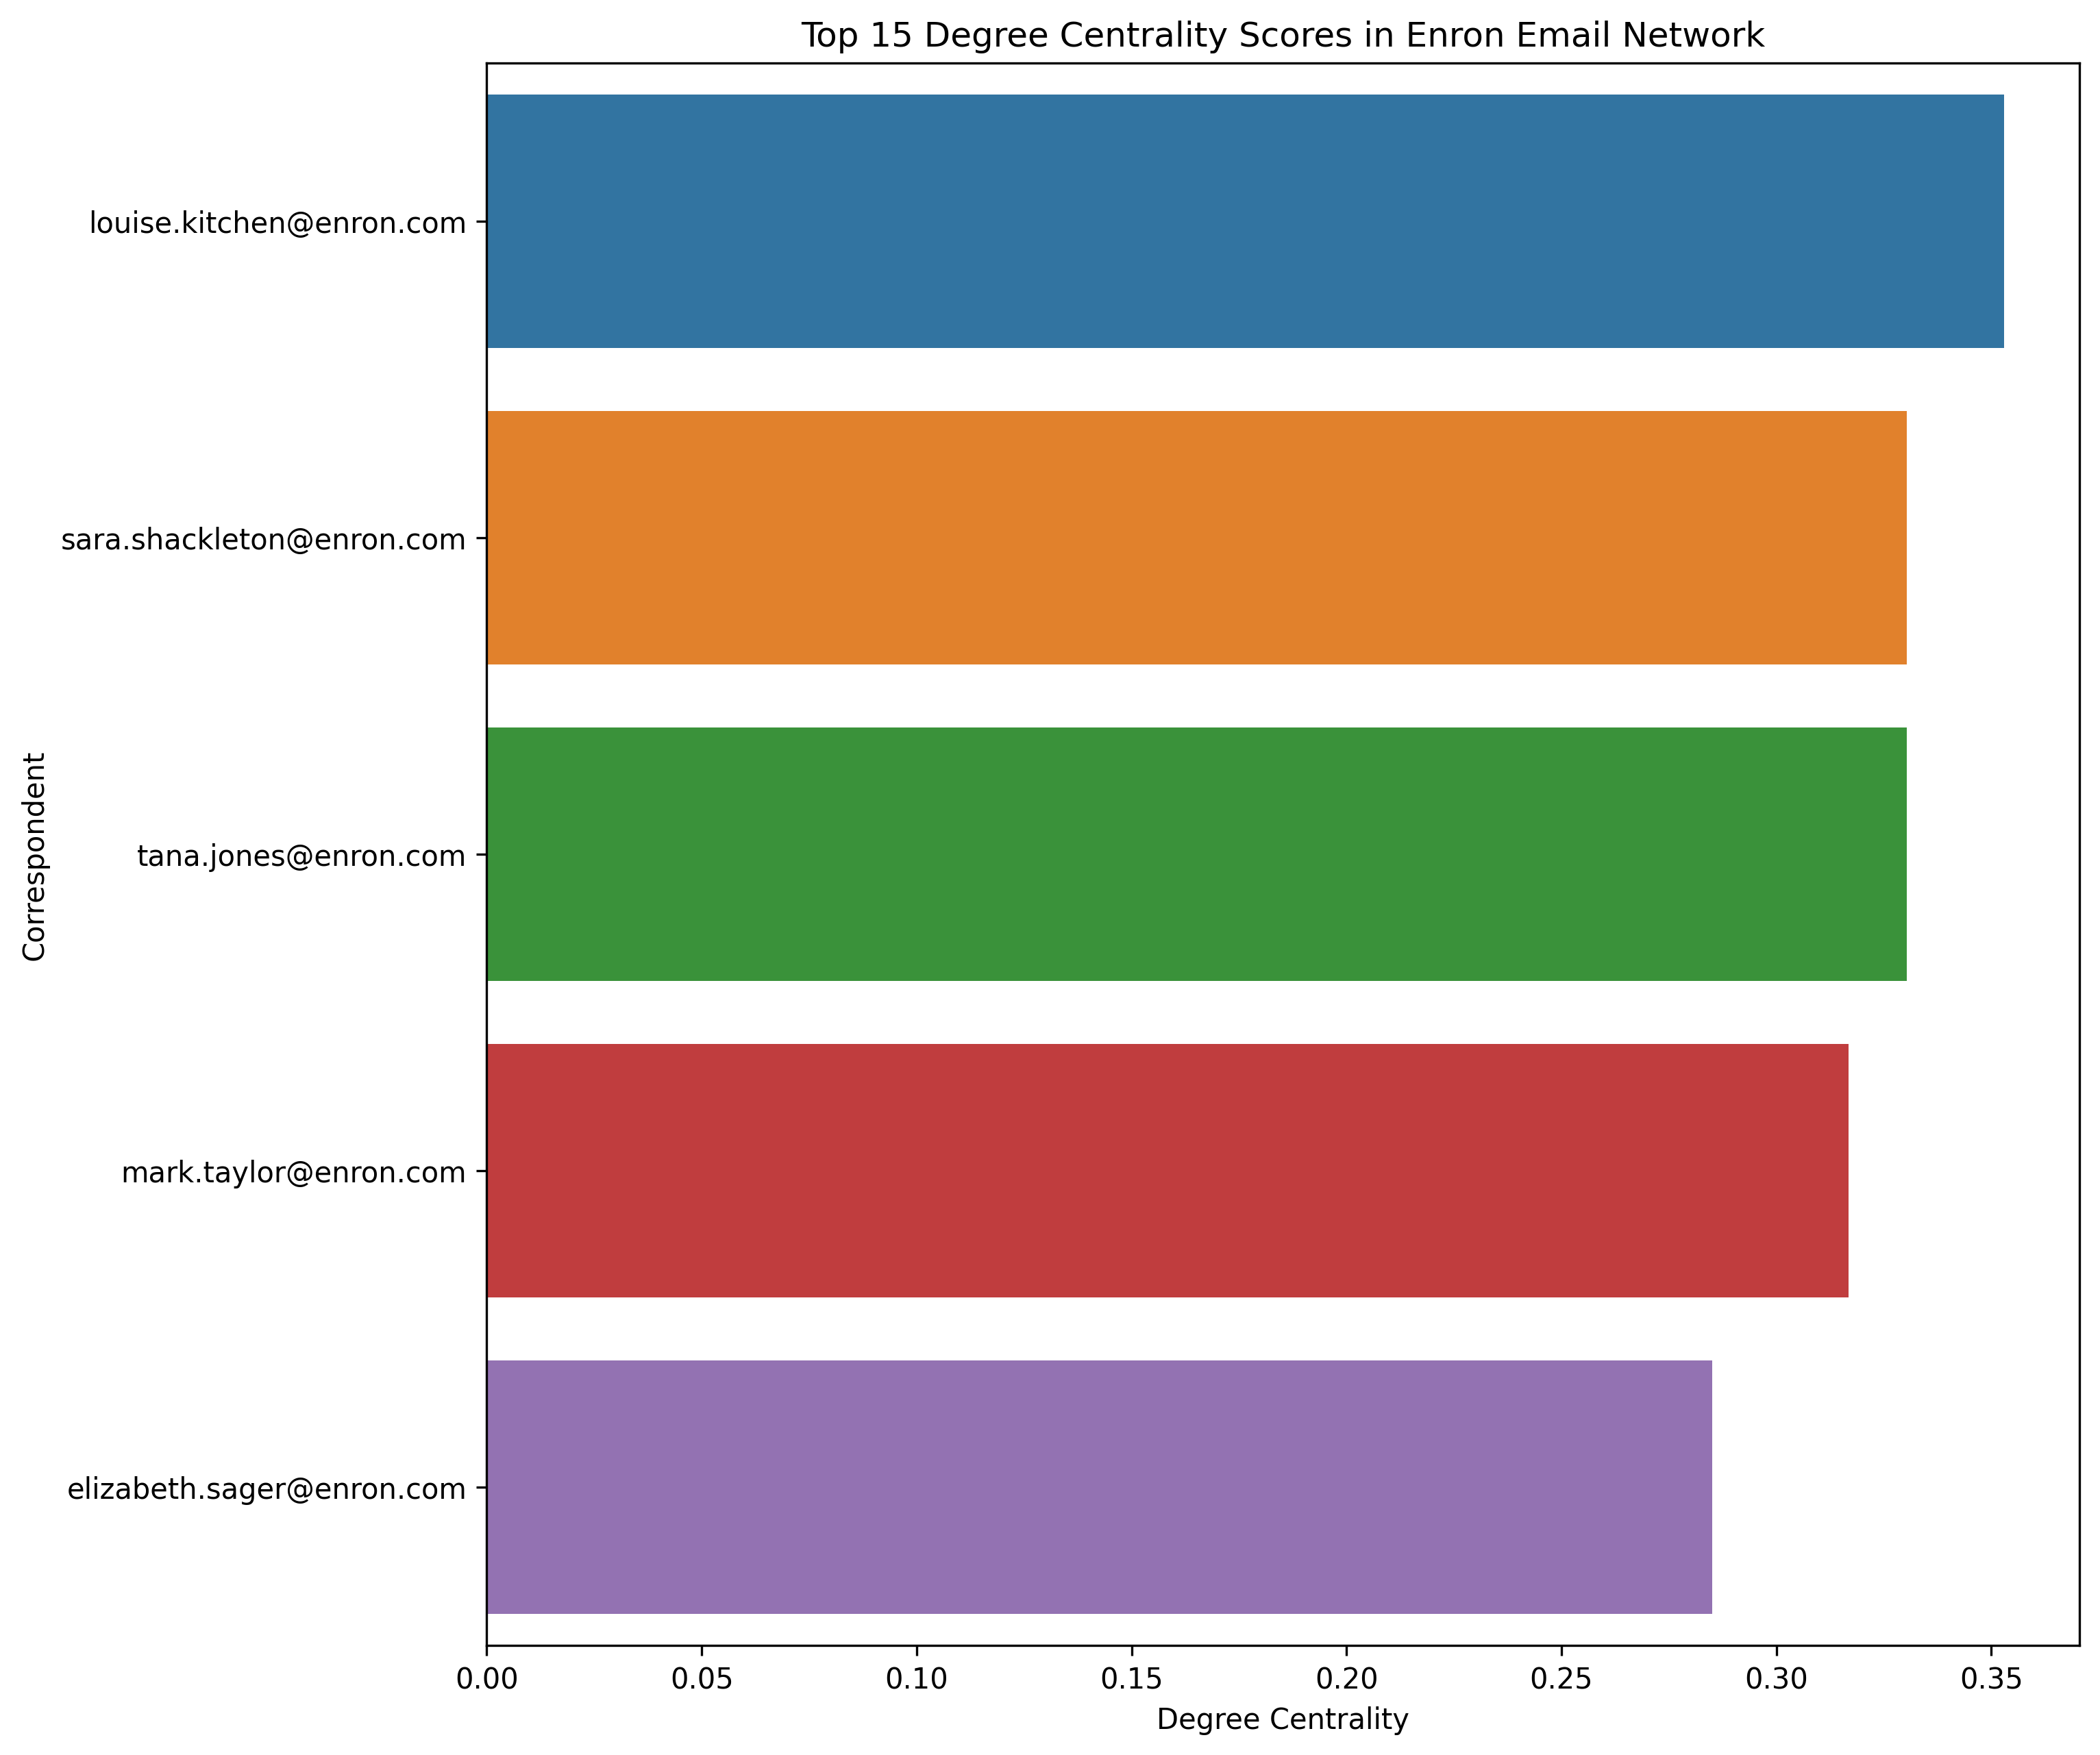

In [7]:
G = nx.from_pandas_edgelist(edges, 'sender', 'recipient1', edge_attr=['date', 'subject'])

cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 10), dpi=300)
_ = sns.barplot(x='centrality', y='name', data=cent[:5], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
print(G.nodes())
print(len(G.nodes()))
plt.savefig('images/centrality.png')
plt.show()



sent_counts = data.groupby('sender').size().rename('sent_count')

# 2. Count number of emails received per person
recv_counts = data.groupby('recipient1').size().rename('recv_count')

# 3. Merge those two counts into one table
counts = pd.concat([sent_counts, recv_counts], axis=1).fillna(0).astype(int)

# 4. Select only those with ≥50 sent AND ≥50 received


# 5. Filter your node list




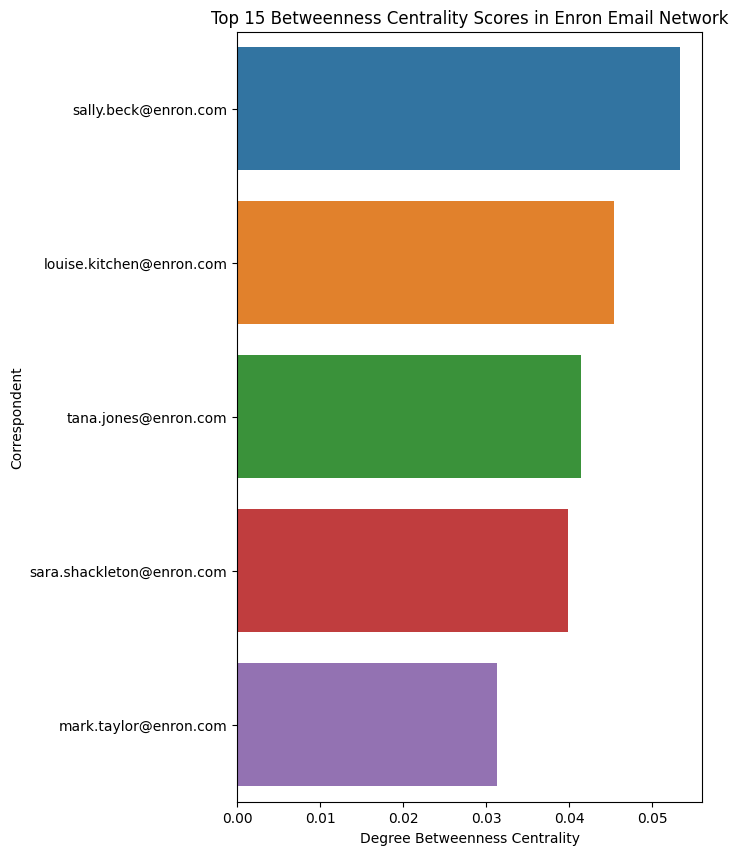

In [8]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(6, 10))
_ = sns.barplot(x='betweenness', y='name', data=bet[:5], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Enron Email Network')
plt.savefig('images/betweenness.png')
plt.show()


In [9]:
#community detection

# Use Louvain method for community detection
communities = nx.community.louvain_communities(G)

# Print number of communities found
print(f"Number of communities detected: {len(communities)}")

# Create a mapping of node to community number
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Add community information to nodes
nx.set_node_attributes(G, community_map, 'community')

# Print size of each community
print("\nCommunity sizes:")
for i, community in enumerate(communities):
    print(f"Community {i}: {len(community)} nodes")

# Visualize top 5 largest communities
community_sizes = [len(c) for c in communities]
top_5_indices = sorted(range(len(community_sizes)), key=lambda k: community_sizes[k], reverse=True)[:5]

plt.figure(figsize=(10, 25))
for idx in top_5_indices:
    community = communities[idx]
    subgraph = G.subgraph(community)
    print(f"\nTop 5 central nodes in community {idx}:")
    # Get degree centrality for nodes in this community
    deg_cent = nx.degree_centrality(subgraph)
    top_nodes = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    for node, centrality in top_nodes:
        print(f"{node}: {centrality:.3f}")


Number of communities detected: 6

Community sizes:
Community 0: 15 nodes
Community 1: 65 nodes
Community 2: 30 nodes
Community 3: 20 nodes
Community 4: 20 nodes
Community 5: 72 nodes

Top 5 central nodes in community 5:
sally.beck@enron.com: 0.521
john.lavorato@enron.com: 0.465
vince.kaminski@enron.com: 0.423
louise.kitchen@enron.com: 0.408
john.arnold@enron.com: 0.380

Top 5 central nodes in community 1:
sara.shackleton@enron.com: 0.844
tana.jones@enron.com: 0.812
mark.taylor@enron.com: 0.781
elizabeth.sager@enron.com: 0.656
carol.clair@enron.com: 0.656

Top 5 central nodes in community 2:
jeff.dasovich@enron.com: 0.966
steven.kean@enron.com: 0.931
richard.shapiro@enron.com: 0.931
susan.mara@enron.com: 0.793
james.steffes@enron.com: 0.793

Top 5 central nodes in community 3:
steven.harris@enron.com: 0.895
tracy.geaccone@enron.com: 0.842
lindy.donoho@enron.com: 0.842
drew.fossum@enron.com: 0.789
kevin.hyatt@enron.com: 0.789

Top 5 central nodes in community 4:
kate.symes@enron.com: 0.

<Figure size 1000x2500 with 0 Axes>

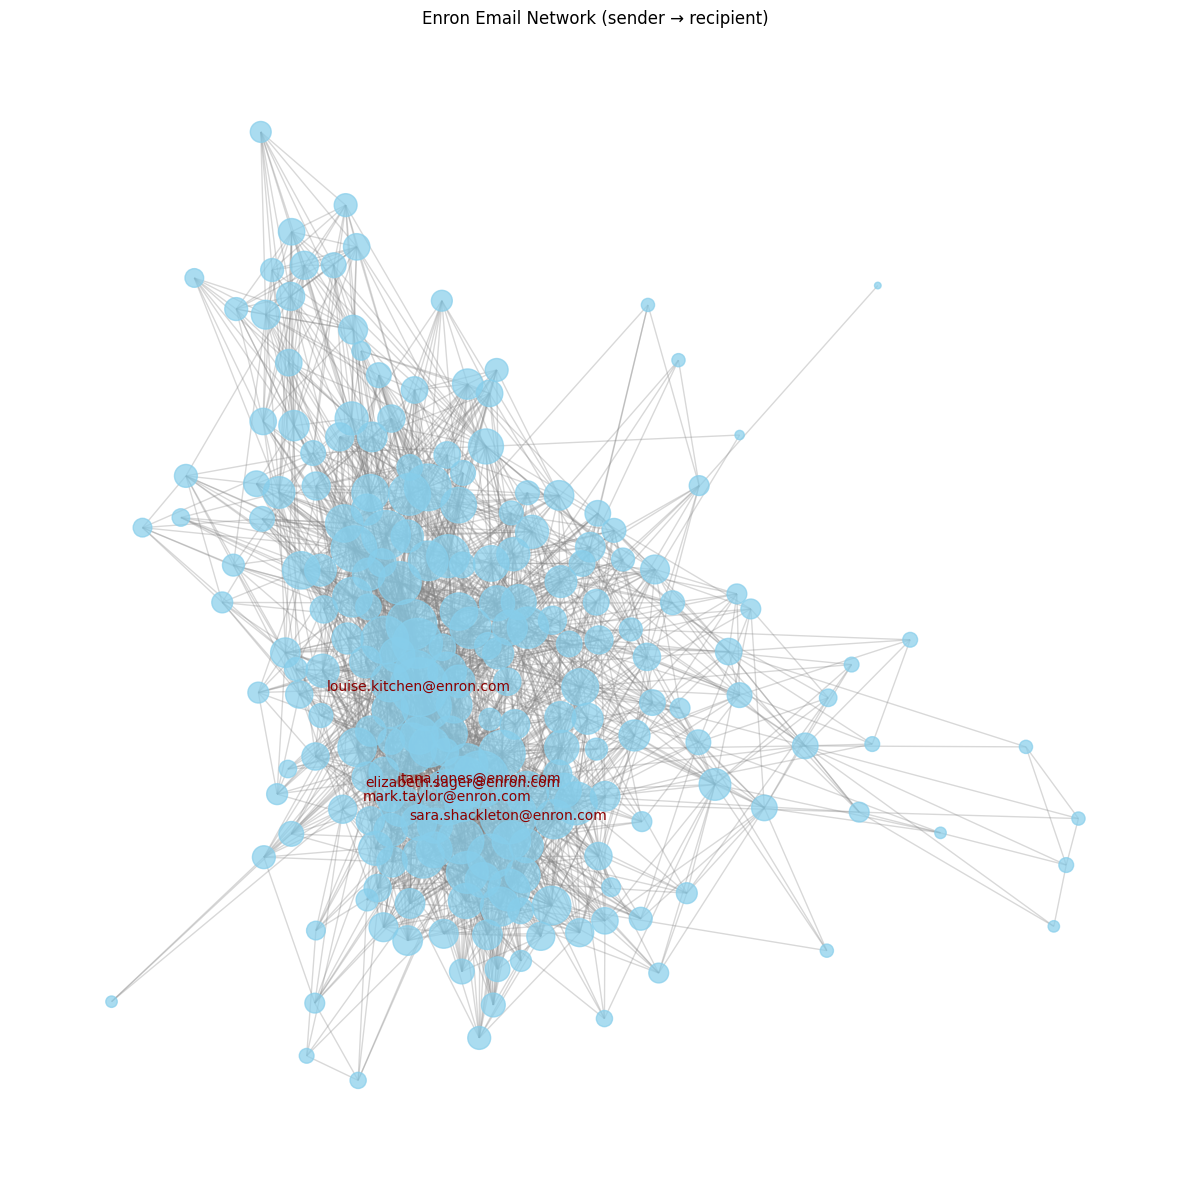

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# 1) Choose a layout
pos = nx.spring_layout(G, k=0.1, iterations=50)

# Compute centrality (e.g., degree centrality)
centrality = nx.degree_centrality(G)

# Scale node sizes (you can tweak the multiplier)
node_sizes = [5000 * centrality[n] for n in G.nodes()]

# 2) Draw nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="skyblue",
    alpha=0.7
)

# 3) Draw edges
nx.draw_networkx_edges(
    G, pos,
    edge_color="gray",
    alpha=0.3
)

# 4) Draw labels for top 5 most-connected nodes
deg = dict(G.degree())
top5 = sorted(deg, key=deg.get, reverse=True)[:5]
labels = {n: n for n in top5}
nx.draw_networkx_labels(
    G, pos,
    labels,
    font_size=10,
    font_color="darkred"
)

plt.axis("off")
plt.title("Enron Email Network (sender → recipient)")
plt.tight_layout()
plt.savefig('images/networkgraph.png')
plt.show()


In [11]:
print("Phillip Allen sent:", send_counts.get('phillip.allen@enron.com', 0))
print("Phillip Allen recv:", recv_counts.get('phillip.allen@enron.com', 0))
# Find communities using Louvain method
import community.community_louvain as community

# Detect communities
communities = community.best_partition(G.to_undirected())

# Find Philip Allen's community
philip_allen_email = 'phillip.allen@enron.com'
if philip_allen_email in communities:
    philip_community = communities[philip_allen_email]
    
    # Get other members of his community
    community_members = [node for node in communities if communities[node] == philip_community]
    
    print("\nPhillip Allen belongs to community", philip_community)
    print("\nOther notable members in his community:")
    # Print top 5 most connected members in his community
    community_degrees = {node: G.degree(node) for node in community_members}
    top_members = sorted(community_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    for member, degree in top_members:
        if member != philip_allen_email:
            print(f"{member}: {degree} connections")
else:
    print("\nPhillip Allen not found in the network")
# Find who Phillip Allen sent the most emails to
phillip_allen_outgoing = [(u,v) for (u,v) in G.edges() if u == 'phillip.allen@enron.com']
recipient_counts = {}

for _, recipient in phillip_allen_outgoing:
    recipient_counts[recipient] = recipient_counts.get(recipient, 0) + 1

# Sort by number of emails sent
top_recipients = sorted(recipient_counts.items(), key=lambda x: x[1], reverse=True)

print("\nPhillip Allen's top recipients:")
for recipient, count in top_recipients[:5]:
    print(f"{recipient}: {count} emails")


# Find an example email from Phillip Allen
phillip_emails = edges[edges['sender'] == 'phillip.allen@enron.com']

if not phillip_emails.empty:
    # Get the first email
    sample_email = phillip_emails.iloc[15]
    
    print("\nExample email from Phillip Allen:")
    print("-" * 50)
    print(f"To: {sample_email['recipient1']}")
    print(f"Date: {sample_email['date']}")
    print(f"Subject: {sample_email['subject']}")
    print("-" * 50)
    print(f"Body:\n{sample_email['text']}")
else:
    print("No emails found from Phillip Allen")



Phillip Allen sent: 1186
Phillip Allen recv: 164

Phillip Allen belongs to community 0

Other notable members in his community:
john.lavorato@enron.com: 59 connections
sally.beck@enron.com: 57 connections
vince.kaminski@enron.com: 48 connections
greg.whalley@enron.com: 42 connections
john.arnold@enron.com: 39 connections

Phillip Allen's top recipients:
tim.belden@enron.com: 1 emails
john.lavorato@enron.com: 1 emails
greg.piper@enron.com: 1 emails
david.delainey@enron.com: 1 emails
jeffrey.hodge@enron.com: 1 emails

Example email from Phillip Allen:
--------------------------------------------------
To: stephanie.sever@enron.com
Date: 2000-08-10 15:02:00-07:00
Subject: Re: Your approval is requested
--------------------------------------------------
Body:

Stephanie

Please grant Paul the requested eol rights

Thanks,
Phillip
